# Baran parameterizations comparison (v2c) - Test 3 - Broadband

Ice Water Path (IWP) test.

Broadband optical property computed as:

$$\frac{\int_\lambda \text{OPT } d\lambda}{\int_\lambda d\lambda}$$

where OPT$(\lambda)$ can be any optical property ($K_{ext}$, $\omega$, $K_{abs}$ and $g$).

In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import pandas as pd
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import ScalarFormatter
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib notebook

In [2]:
# set the colormap and centre the colorbar for heatmaps
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

Reading Tropical Climatology and Test input files (three levels). Create one matrix with three levels together:

In [3]:
in_dir       = ('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/1-ecrad_inputs/')
file201      = 'input_1Dset_test3_201_v7a.nc'
file218      = 'input_1Dset_test3_218_v7a.nc'
file236      = 'input_1Dset_test3_236_v7a.nc'
test3_201_in = xr.open_dataset(in_dir + file201)
test3_218_in = xr.open_dataset(in_dir + file218)
test3_236_in = xr.open_dataset(in_dir + file236)

In [4]:
test3_qice   = test3_201_in.q_ice.values + test3_218_in.q_ice.values + test3_236_in.q_ice.values

In [5]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/tropical_profile_ellingson_250m.txt',
                               sep = '\s+ ')

/tmp/ipykernel_13390/1069832010.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/tropical_profile_ellingson_250m.txt',


In [6]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(test3_201_in.pressure_hl.values)

height_int     = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['height (km)'].iloc[::-1])
height_hl      = height_int(test3_201_in.pressure_hl.values)

$\Delta T$ of around 1 degree. Consider this when computing LUT for Baran16. Use a 0.5 degree resolution.

In [7]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

height_hl_pd    = pd.Series(height_hl[0])

In [8]:
iwp = np.logspace(np.log10(.1),np.log10(1000), 2000)

Reading Optical Schemes LUT

In [9]:
in_dir     = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')

fu_sw      = xr.open_dataset(in_dir + 'FuSW_LUT_v2a.nc')
fu_lw      = xr.open_dataset(in_dir + 'FuLW_LUT_v2a.nc')
baran14_sw = xr.open_dataset(in_dir + 'Baran14SW_LUT_v2a.nc')
baran14_lw = xr.open_dataset(in_dir + 'Baran14LW_LUT_v2a.nc')
baran16_sw = xr.open_dataset(in_dir + 'Baran16SW_LUT_v2a.nc')
baran16_lw = xr.open_dataset(in_dir + 'Baran16LW_LUT_v2a.nc')

Reading Fu optical scheme wavelength bands:

In [10]:
# This seems to be the one used in ecRad calculations:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_rad_data_backup/')
file      = 'fu_ice_scattering_rrtm.nc'
#fu_scatt  = xr.open_dataset(data_path+file, drop_variables='siglay')
fu_scatt  = nc.Dataset(data_path+file)

In [11]:
fu_sw_wn1 = fu_scatt.variables['wavenumber1_sw'][:]
fu_sw_wn2 = fu_scatt.variables['wavenumber2_sw'][:]

fu_lw_wn1 = fu_scatt.variables['wavenumber1_lw'][:]
fu_lw_wn2 = fu_scatt.variables['wavenumber2_lw'][:]

## Mass Extinction Coefficient $K_{ext}$ $(m^2/g)$:

Position of 30 um (Fixed Size):

In [12]:
# Ice Mass Mixing ratio qi (kg/kg) (from LUT):
q_i = np.arange(0.1e-3, 0.7001, 0.1e-3) * 0.001 #np.arange(0.04, 0.11, 0.001) * 0.001 # Old Range used in Test 1 - Altitude/Temperature.

# Temperature
T = np.arange(190, 260.5, .5) # Temperature (K)

# Effective Radius (um)
r_e  = np.arange(5, 60, 1)

pos30 = np.where(r_e == 30)[0][0]

In [13]:
fu_sw_K_ext = fu_sw.K_ext.values
fu_lw_K_ext = fu_lw.K_ext.values
baran14_sw_K_ext = baran14_sw.K_ext.values
baran14_lw_K_ext = baran14_lw.K_ext.values
baran16_sw_K_ext = baran16_sw.K_ext.values
baran16_lw_K_ext = baran16_lw.K_ext.values

I like to check the table in excel:

In [14]:
# np.savetxt('out_tables_to_check/fu_lw_Kext.csv', fu_lw_K_ext[:,pos30,0], delimiter = ",")
# np.savetxt('out_tables_to_check/b14_lw_Kext.csv', baran14_lw_K_ext, delimiter = ",")
# np.savetxt('out_tables_to_check/lw_wl1.csv', 1e4/eval('fu_lw_wn1'), delimiter = ",")
# np.savetxt('out_tables_to_check/lw_wl2.csv', 1e4/eval('fu_lw_wn2'), delimiter = ",")
# np.savetxt('out_tables_to_check/q_i.csv', q_i, delimiter = ",")

Be careful, compute only until 200 g m$^{-2}$:

In [15]:
lim200 = np.where(iwp == min(iwp, key = lambda x: abs(x - 200)))[0][0]

In [16]:
#iwpi  = test3_201_in.sizes['column']     # Temperature Levels
profi = test3_201_in.sizes['half_level']  # Vertical Profile

sw_bands = list(np.arange(0,13)[::-1])
lw_bands = list(np.arange(1,16)[::-1])

## K_ext Calculation Matrices:
K_ext_sw_t3_bb = np.zeros((3, len(iwp[:lim200]), profi))
K_ext_lw_t3_bb = np.zeros((3, len(iwp[:lim200]), profi))

## Matrices for plotting:
K_ext_sw_t3_bb_plot = np.zeros((3, profi, len(iwp[:lim200])))
K_ext_lw_t3_bb_plot = np.zeros((3, profi, len(iwp[:lim200])))

for sch in range(3): # per optical scheme (1,3): Fu, Baran14, Baran16
    for i in range(len(iwp[:lim200])):
        pres     = test3_201_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = test3_qice[i]                      # Ice Water Mixing Ratio (kg / kg) from logscale input file
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: # If there is no Ice cloud, Kext = 0
                K_ext_sw_t3_bb[sch, i, q_ix] = 0
                K_ext_lw_t3_bb[sch, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_qidiff   = q_difference.argmin()
                #print(sch, i, min_i)
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                fu_sw_bb_K_ext  = 0
                b14_sw_bb_K_ext = 0
                b16_sw_bb_K_ext = 0
                for sw_band in sw_bands:
                    Dl = 1e4/fu_sw_wn1[sw_band] - 1e4/fu_sw_wn2[sw_band]
                    fu_sw_bb_K_ext  += fu_sw_K_ext[sw_band, pos30]*Dl
                    b14_sw_bb_K_ext += baran14_sw_K_ext[sw_band, min_qidiff]*Dl
                    b16_sw_bb_K_ext += baran16_sw_K_ext[sw_band, min_qidiff, min_Tdiff]*Dl
                K_ext_sw_t3_bb[0, i, q_ix] = fu_sw_bb_K_ext
                K_ext_sw_t3_bb[1, i, q_ix] = b14_sw_bb_K_ext 
                K_ext_sw_t3_bb[2, i, q_ix] = b16_sw_bb_K_ext
                
                fu_lw_bb_K_ext  = 0
                b14_lw_bb_K_ext = 0
                b16_lw_bb_K_ext = 0
                for lw_band in lw_bands:
                    Dl = 1e4/fu_lw_wn1[lw_band] - 1e4/fu_lw_wn2[lw_band]
                    fu_lw_bb_K_ext  += fu_lw_K_ext[lw_band, pos30]*Dl
                    b14_lw_bb_K_ext += baran14_lw_K_ext[lw_band, min_qidiff]*Dl
                    b16_lw_bb_K_ext += baran16_lw_K_ext[lw_band, min_qidiff, min_Tdiff]*Dl
                K_ext_lw_t3_bb[0, i, q_ix] = fu_lw_bb_K_ext
                K_ext_lw_t3_bb[1, i, q_ix] = b14_lw_bb_K_ext 
                K_ext_lw_t3_bb[2, i, q_ix] = b16_lw_bb_K_ext
                
    # For plotting:
    K_ext_sw_t3_bb_plot[sch,:,:] = np.transpose(K_ext_sw_t3_bb[sch,:,:])
    K_ext_lw_t3_bb_plot[sch,:,:] = np.transpose(K_ext_lw_t3_bb[sch,:,:])

### Figure with relative difference:

In [17]:
# Shortwave:
K_ext_sw_t3_bb_diff_plot_RD    = np.zeros((2, profi, len(iwp[:lim200])))
# Baran2014 - Fu
K_ext_sw_t3_bb_diff_plot_RD[0] = ((K_ext_sw_t3_bb_plot[1] - K_ext_sw_t3_bb_plot[0])/K_ext_sw_t3_bb_plot[0])*100
# Baran2016 - Fu
K_ext_sw_t3_bb_diff_plot_RD[1] = ((K_ext_sw_t3_bb_plot[2] - K_ext_sw_t3_bb_plot[0])/K_ext_sw_t3_bb_plot[0])*100

# Longwave:
K_ext_lw_t3_bb_diff_plot_RD    = np.zeros((2, profi, len(iwp[:lim200])))
# Baran2014 - Fu
K_ext_lw_t3_bb_diff_plot_RD[0] = ((K_ext_lw_t3_bb_plot[1] - K_ext_lw_t3_bb_plot[0])/K_ext_lw_t3_bb_plot[0])*100
# Baran2016 - Fu
K_ext_lw_t3_bb_diff_plot_RD[1] = ((K_ext_lw_t3_bb_plot[2] - K_ext_lw_t3_bb_plot[0])/K_ext_lw_t3_bb_plot[0])*100

/tmp/ipykernel_13390/3076991494.py:4: RuntimeWarning: invalid value encountered in divide
  K_ext_sw_t3_bb_diff_plot_RD[0] = ((K_ext_sw_t3_bb_plot[1] - K_ext_sw_t3_bb_plot[0])/K_ext_sw_t3_bb_plot[0])*100
/tmp/ipykernel_13390/3076991494.py:6: RuntimeWarning: invalid value encountered in divide
  K_ext_sw_t3_bb_diff_plot_RD[1] = ((K_ext_sw_t3_bb_plot[2] - K_ext_sw_t3_bb_plot[0])/K_ext_sw_t3_bb_plot[0])*100
/tmp/ipykernel_13390/3076991494.py:11: RuntimeWarning: invalid value encountered in divide
  K_ext_lw_t3_bb_diff_plot_RD[0] = ((K_ext_lw_t3_bb_plot[1] - K_ext_lw_t3_bb_plot[0])/K_ext_lw_t3_bb_plot[0])*100
/tmp/ipykernel_13390/3076991494.py:13: RuntimeWarning: invalid value encountered in divide
  K_ext_lw_t3_bb_diff_plot_RD[1] = ((K_ext_lw_t3_bb_plot[2] - K_ext_lw_t3_bb_plot[0])/K_ext_lw_t3_bb_plot[0])*100


In [18]:
# Shortwave K_ext differences:
print('Shortwave CRH Differences:')
b14_fu_min_sw = np.nanmin(K_ext_sw_t3_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_sw)
b14_fu_max_sw = np.nanmax(K_ext_sw_t3_bb_diff_plot_RD[0][np.nonzero(K_ext_sw_t3_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_sw)
b16_fu_min_sw = np.nanmin(K_ext_sw_t3_bb_diff_plot_RD[1])
print('Baran2016 - Fu min: ', b16_fu_min_sw)
b16_fu_max_sw = np.nanmax(K_ext_sw_t3_bb_diff_plot_RD[1])
print('Baran2016 - Fu max: ', b16_fu_max_sw)

print('')
# Longwave K_ext differences:
print('Longwave CRH Differences:')
b14_fu_min_lw = np.nanmin(K_ext_lw_t3_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_lw)
b14_fu_max_lw = np.nanmax(K_ext_lw_t3_bb_diff_plot_RD[0][np.nonzero(K_ext_lw_t3_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_lw)
b16_fu_min_lw = np.nanmin(K_ext_lw_t3_bb_diff_plot_RD[1][np.nonzero(K_ext_lw_t3_bb_diff_plot_RD[1])])
print('Baran2016 - Fu min: ', b16_fu_min_lw)
b16_fu_max_lw = np.nanmax(K_ext_lw_t3_bb_diff_plot_RD[1][np.nonzero(K_ext_lw_t3_bb_diff_plot_RD[1])])
print('Baran2016 - Fu max: ', b16_fu_max_lw)

Shortwave CRH Differences:
Baran2014 - Fu min:  -7.343369328126748
Baran2014 - Fu max:  -4.244855188435147
Baran2016 - Fu min:  -9.247807093125221
Baran2016 - Fu max:  100.27603285719373

Longwave CRH Differences:
Baran2014 - Fu min:  -11.393532753915954
Baran2014 - Fu max:  -9.240573271168369
Baran2016 - Fu min:  -9.623066160555362
Baran2016 - Fu max:  99.4478942204148


<IPython.core.display.Javascript object>


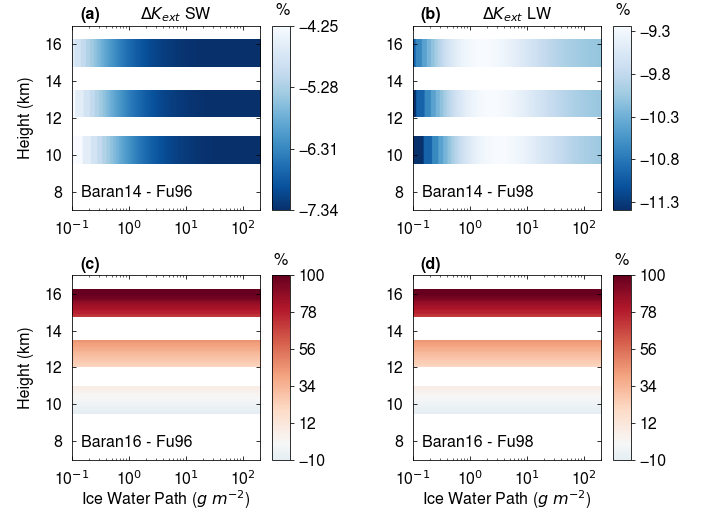

In [19]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 7.1 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for schi in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if schi == 0:
        # For SW:
        vmini_sw   = -7.34
        vmaxi_sw   = -4.25
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 4)
        cmap_sw    = 'Blues_r'
        norm_sw    = None
        
        #For LW:
        vmini_lw   = -11.3
        vmaxi_lw   = -9.3
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 5)
        cmap_lw    = 'Blues_r'
        norm_lw    = None
        
        labelpad   = -57
    else:
        # For SW:
        vmini_sw   = -10
        vmaxi_sw   = 100
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 6)
        cmap_sw    = 'RdBu_r'
        norm_sw    = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)#colors.PowerNorm(gamma = 0.01)
        
        #For LW:
        vmini_lw   = -10
        vmaxi_lw   = 100
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'RdBu_r'
        norm_lw    = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)#colors.PowerNorm(gamma = 0.01)
        
        labelpad   = -45
         
    # Shortwave K_ext Difference
    im = ax[schi, 0].imshow(K_ext_sw_t3_bb_diff_plot_RD[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #if schi == 0: cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 0].set_title(r'$\Delta K_{ext}$ SW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave K_ext Difference
    im = ax[schi, 1].imshow(K_ext_lw_t3_bb_diff_plot_RD[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 1].set_title(r'$\Delta K_{ext}$ LW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis:
yticks      = np.arange(0, profi+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis: # Logscale ticklabels are built manually:
major_xticklabels = np.logspace(np.log10(0.1), np.log10(100), 4)
minor_xticklabels = list(np.linspace(0.1, 1, 10))[:-1] + list(np.linspace(1, 10, 10))[:-1] + list(np.linspace(10, 100, 10)) + [200]
major_xticks      = []
minor_xticks      = []
for xticklabelsi in major_xticklabels:
    major_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])
for xticklabelsi in minor_xticklabels:
    minor_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Ice Water Path ($g$ $m^{-2}$)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 0)
        ax[diff, j].set_xticks(major_xticks)
        ax[diff, j].set_xticks(minor_xticks, minor = True)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        ax[diff, j].tick_params(axis = 'x', which = 'minor', color = 'black',
                                size = 2, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)   
        #ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(major_xticklabels)
        ax[diff, j].set_xticklabels([r'10$^{-1}$', r'10$^{0}$', r'10$^{1}$', r'10$^{2}$'])
        #ax[diff, j].set_xlim(0.1, 2000)
        #ax[diff, j].set_xscale('log')
        
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.05, 0.05, Diff_sw[diff],
                             ha = 'left', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.05, 0.05, Diff_lw[diff],
                             ha = 'left', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 7).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.1, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_Kext_barans_Rdiff_SM_v2c.png', dpi=500)

Saving colorbar characteristics per scheme (tickbars, cmap, norm):

In [20]:
K_ext_sw_t3_bb_RD_colorbar = [[np.linspace(-7.34, -4.25, 4), 'Blues_r', None],
                              [np.linspace(-10, 100, 6), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -10, vmax = 100)]]
K_ext_lw_t3_bb_RD_colorbar = [[np.linspace(-11.3, -9.3, 5), 'Blues_r', None],
                              [np.linspace(-10, 100, 6), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -10, vmax = 100)]]

## Single Scatter Albedo $\omega_0$

Position of 30 um (Fixed Size). Already defined for Extinction Coefficient:

In [21]:
fu_sw_ssa = fu_sw.ssa.values
fu_lw_ssa = fu_lw.ssa.values
baran14_sw_ssa = baran14_sw.ssa.values
baran14_lw_ssa = baran14_lw.ssa.values
baran16_sw_ssa = baran16_sw.ssa.values
baran16_lw_ssa = baran16_lw.ssa.values

I like to check the table in excel:

In [22]:
# np.savetxt('out_tables_to_check/fu_lw_ssa.csv', fu_lw_ssa[:,pos30,0], delimiter = ",")
# np.savetxt('out_tables_to_check/b14_lw_ssa.csv', baran14_lw_ssa, delimiter = ",")

Be careful, compute only until 200 g m$^{-2}$:

In [23]:
lim200 = np.where(iwp == min(iwp, key = lambda x: abs(x - 200)))[0][0]

In [24]:
#iwpi  = test3_201_in.sizes['column']     # Temperature Levels
profi = test3_201_in.sizes['half_level']  # Vertical Profile

sw_bands = list(np.arange(0,13)[::-1])
lw_bands = list(np.arange(1,16)[::-1])

## ssa Calculation Matrices:
ssa_sw_t3_bb = np.zeros((3, len(iwp[:lim200]), profi))
ssa_lw_t3_bb = np.zeros((3, len(iwp[:lim200]), profi))

## Matrices for plotting:
ssa_sw_t3_bb_plot = np.zeros((3, profi, len(iwp[:lim200])))
ssa_lw_t3_bb_plot = np.zeros((3, profi, len(iwp[:lim200])))

for sch in range(3): # per optical scheme (1,3): Fu, Baran14, Baran16
    for i in range(len(iwp[:lim200])):
        pres     = test3_201_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = test3_qice[i]                      # Ice Water Mixing Ratio (kg / kg) from logscale input file
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: # If there is no Ice cloud, Kext = 0
                ssa_sw_t3_bb[sch, i, q_ix] = 0
                ssa_lw_t3_bb[sch, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_qidiff   = q_difference.argmin()
                #print(sch, i, min_i)
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                fu_sw_bb_ssa  = 0
                b14_sw_bb_ssa = 0
                b16_sw_bb_ssa = 0
                for sw_band in sw_bands:
                    Dl = 1e4/fu_sw_wn1[sw_band] - 1e4/fu_sw_wn2[sw_band]
                    fu_sw_bb_ssa  += fu_sw_ssa[sw_band, pos30]*Dl
                    b14_sw_bb_ssa += baran14_sw_ssa[sw_band, min_qidiff]*Dl
                    b16_sw_bb_ssa += baran16_sw_ssa[sw_band, min_qidiff, min_Tdiff]*Dl
                ssa_sw_t3_bb[0, i, q_ix] = fu_sw_bb_ssa
                ssa_sw_t3_bb[1, i, q_ix] = b14_sw_bb_ssa 
                ssa_sw_t3_bb[2, i, q_ix] = b16_sw_bb_ssa
                
                fu_lw_bb_ssa  = 0
                b14_lw_bb_ssa = 0
                b16_lw_bb_ssa = 0
                for lw_band in lw_bands:
                    Dl = 1e4/fu_lw_wn1[lw_band] - 1e4/fu_lw_wn2[lw_band]
                    fu_lw_bb_ssa  += fu_lw_ssa[lw_band, pos30]*Dl
                    b14_lw_bb_ssa += baran14_lw_ssa[lw_band, min_qidiff]*Dl
                    b16_lw_bb_ssa += baran16_lw_ssa[lw_band, min_qidiff, min_Tdiff]*Dl
                ssa_lw_t3_bb[0, i, q_ix] = fu_lw_bb_ssa
                ssa_lw_t3_bb[1, i, q_ix] = b14_lw_bb_ssa 
                ssa_lw_t3_bb[2, i, q_ix] = b16_lw_bb_ssa
                
    # For plotting:
    ssa_sw_t3_bb_plot[sch,:,:] = np.transpose(ssa_sw_t3_bb[sch,:,:])
    ssa_lw_t3_bb_plot[sch,:,:] = np.transpose(ssa_lw_t3_bb[sch,:,:])

### Figure with relative difference

In [25]:
# Shortwave:
ssa_sw_t3_bb_diff_plot_RD    = np.zeros((2, profi, len(iwp[:lim200])))
# Baran2014 - Fu
ssa_sw_t3_bb_diff_plot_RD[0] = ((ssa_sw_t3_bb_plot[1] - ssa_sw_t3_bb_plot[0])/ssa_sw_t3_bb_plot[0])*100
# Baran2016 - Fu
ssa_sw_t3_bb_diff_plot_RD[1] = ((ssa_sw_t3_bb_plot[2] - ssa_sw_t3_bb_plot[0])/ssa_sw_t3_bb_plot[0])*100

# Longwave:
ssa_lw_t3_bb_diff_plot_RD    = np.zeros((2, profi, len(iwp[:lim200])))
# Baran2014 - Fu
ssa_lw_t3_bb_diff_plot_RD[0] = ((ssa_lw_t3_bb_plot[1] - ssa_lw_t3_bb_plot[0])/ssa_lw_t3_bb_plot[0])*100
# Baran2016 - Fu
ssa_lw_t3_bb_diff_plot_RD[1] = ((ssa_lw_t3_bb_plot[2] - ssa_lw_t3_bb_plot[0])/ssa_lw_t3_bb_plot[0])*100

/tmp/ipykernel_13390/4260537477.py:4: RuntimeWarning: invalid value encountered in divide
  ssa_sw_t3_bb_diff_plot_RD[0] = ((ssa_sw_t3_bb_plot[1] - ssa_sw_t3_bb_plot[0])/ssa_sw_t3_bb_plot[0])*100
/tmp/ipykernel_13390/4260537477.py:6: RuntimeWarning: invalid value encountered in divide
  ssa_sw_t3_bb_diff_plot_RD[1] = ((ssa_sw_t3_bb_plot[2] - ssa_sw_t3_bb_plot[0])/ssa_sw_t3_bb_plot[0])*100
/tmp/ipykernel_13390/4260537477.py:11: RuntimeWarning: invalid value encountered in divide
  ssa_lw_t3_bb_diff_plot_RD[0] = ((ssa_lw_t3_bb_plot[1] - ssa_lw_t3_bb_plot[0])/ssa_lw_t3_bb_plot[0])*100
/tmp/ipykernel_13390/4260537477.py:13: RuntimeWarning: invalid value encountered in divide
  ssa_lw_t3_bb_diff_plot_RD[1] = ((ssa_lw_t3_bb_plot[2] - ssa_lw_t3_bb_plot[0])/ssa_lw_t3_bb_plot[0])*100


In [26]:
# Shortwave ssa differences:
print('Shortwave CRH Differences:')
b14_fu_min_sw = np.nanmin(ssa_sw_t3_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_sw)
b14_fu_max_sw = np.nanmax(ssa_sw_t3_bb_diff_plot_RD[0][np.nonzero(ssa_sw_t3_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_sw)
b16_fu_min_sw = np.nanmin(ssa_sw_t3_bb_diff_plot_RD[1])
print('Baran2016 - Fu min: ', b16_fu_min_sw)
b16_fu_max_sw = np.nanmax(ssa_sw_t3_bb_diff_plot_RD[1])
print('Baran2016 - Fu max: ', b16_fu_max_sw)

print('')
# Longwave ssa differences:
print('Longwave CRH Differences:')
b14_fu_min_lw = np.nanmin(ssa_lw_t3_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_lw)
b14_fu_max_lw = np.nanmax(ssa_lw_t3_bb_diff_plot_RD[0][np.nonzero(ssa_lw_t3_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_lw)
b16_fu_min_lw = np.nanmin(ssa_lw_t3_bb_diff_plot_RD[1][np.nonzero(ssa_lw_t3_bb_diff_plot_RD[1])])
print('Baran2016 - Fu min: ', b16_fu_min_lw)
b16_fu_max_lw = np.nanmax(ssa_lw_t3_bb_diff_plot_RD[1][np.nonzero(ssa_lw_t3_bb_diff_plot_RD[1])])
print('Baran2016 - Fu max: ', b16_fu_max_lw)

Shortwave CRH Differences:
Baran2014 - Fu min:  -2.5454545275482086
Baran2014 - Fu max:  7.107714841265246
Baran2016 - Fu min:  5.166218141357224
Baran2016 - Fu max:  8.779032792667273

Longwave CRH Differences:
Baran2014 - Fu min:  -7.997673227244957
Baran2014 - Fu max:  11.438742420628131
Baran2016 - Fu min:  2.0344383864471793
Baran2016 - Fu max:  4.824322592117521


<IPython.core.display.Javascript object>


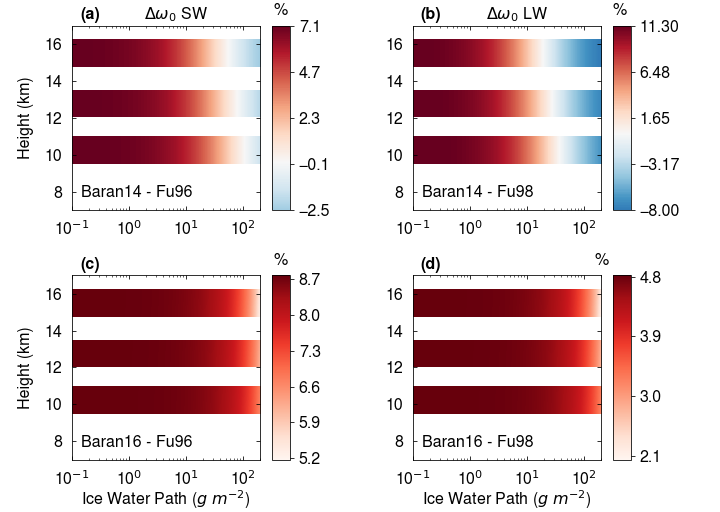

In [27]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 7.1 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for schi in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if schi == 0:
        # For SW:
        vmini_sw   = -2.5
        vmaxi_sw   = 7.1
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 5)
        cmap_sw    = 'RdBu_r'
        norm_sw    = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        
        #For LW:
        vmini_lw   = -8
        vmaxi_lw   = 11.3
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 5)
        cmap_lw    = 'RdBu_r'
        norm_lw    = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)
        
        labelpad   = -50
    else:
        # For SW:
        vmini_sw   = 5.2
        vmaxi_sw   = 8.7
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 6)
        cmap_sw    = 'Reds'
        norm_sw    = None
        
        #For LW:
        vmini_lw   = 2.1
        vmaxi_lw   = 4.8
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 4)
        cmap_lw    = 'Reds'
        norm_lw    = None
        
        labelpad   = -40
         
    # Shortwave ssa Difference
    im = ax[schi, 0].imshow(ssa_sw_t3_bb_diff_plot_RD[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #if schi == 0: cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 0].set_title(r'$\Delta \omega_{0}$ SW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)
    
    labelpad = -60
    # Longwave ssa Difference
    im = ax[schi, 1].imshow(ssa_lw_t3_bb_diff_plot_RD[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 1].set_title(r'$\Delta \omega_{0}$ LW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis:
yticks      = np.arange(0, profi+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis: # Logscale ticklabels are built manually:
major_xticklabels = np.logspace(np.log10(0.1), np.log10(100), 4)
minor_xticklabels = list(np.linspace(0.1, 1, 10))[:-1] + list(np.linspace(1, 10, 10))[:-1] + list(np.linspace(10, 100, 10)) + [200]
major_xticks      = []
minor_xticks      = []
for xticklabelsi in major_xticklabels:
    major_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])
for xticklabelsi in minor_xticklabels:
    minor_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Ice Water Path ($g$ $m^{-2}$)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 0)
        ax[diff, j].set_xticks(major_xticks)
        ax[diff, j].set_xticks(minor_xticks, minor = True)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        ax[diff, j].tick_params(axis = 'x', which = 'minor', color = 'black',
                                size = 2, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)   
        #ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(major_xticklabels)
        ax[diff, j].set_xticklabels([r'10$^{-1}$', r'10$^{0}$', r'10$^{1}$', r'10$^{2}$'])
        #ax[diff, j].set_xlim(0.1, 2000)
        #ax[diff, j].set_xscale('log')
        
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.05, 0.05, Diff_sw[diff],
                             ha = 'left', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.05, 0.05, Diff_lw[diff],
                             ha = 'left', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 7).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.1, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_Kext_barans_Rdiff_SM_v2c.png', dpi=500)

Saving colorbar characteristics per scheme (tickbars, cmap, norm):

In [28]:
ssa_sw_t3_bb_RD_colorbar = [[np.linspace(-2.5, 7.1, 5), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -2.5, vmax = 7.1)],
                            [np.linspace(5.2, 8.7, 6), 'Reds', None]]
ssa_lw_t3_bb_RD_colorbar = [[np.linspace(-8, 11.3, 5), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -8, vmax = 11.3)],
                            [np.linspace(2.1, 4.8, 4), 'Reds', None]]

## Mass Absorption Coefficient $K_{abs}$ $(m^2/g)$:

Position of 30 um (Fixed Size). Already defined for Extinction Coefficient:

In [29]:
fu_sw_K_abs = fu_sw.K_abs.values
fu_lw_K_abs = fu_lw.K_abs.values
baran14_sw_K_abs = baran14_sw.K_abs.values
baran14_lw_K_abs = baran14_lw.K_abs.values
baran16_sw_K_abs = baran16_sw.K_abs.values
baran16_lw_K_abs = baran16_lw.K_abs.values

I like to check the table in excel:

In [30]:
# np.savetxt('out_tables_to_check/fu_lw_Kext.csv', fu_lw_K_ext[:,pos30,0], delimiter = ",")
# np.savetxt('out_tables_to_check/b14_lw_Kext.csv', baran14_lw_K_ext, delimiter = ",")
# np.savetxt('out_tables_to_check/lw_wl1.csv', 1e4/eval('fu_lw_wn1'), delimiter = ",")
# np.savetxt('out_tables_to_check/lw_wl2.csv', 1e4/eval('fu_lw_wn2'), delimiter = ",")
# np.savetxt('out_tables_to_check/q_i.csv', q_i, delimiter = ",")

Be careful, compute only until 200 g m$^{-2}$:

In [31]:
lim200 = np.where(iwp == min(iwp, key = lambda x: abs(x - 200)))[0][0]

In [32]:
#iwpi  = test3_201_in.sizes['column']     # Temperature Levels
profi = test3_201_in.sizes['half_level']  # Vertical Profile

sw_bands = list(np.arange(0,13)[::-1])
lw_bands = list(np.arange(1,16)[::-1])

## K_abs Calculation Matrices:
K_abs_sw_t3_bb = np.zeros((3, len(iwp[:lim200]), profi))
K_abs_lw_t3_bb = np.zeros((3, len(iwp[:lim200]), profi))

## Matrices for plotting:
K_abs_sw_t3_bb_plot = np.zeros((3, profi, len(iwp[:lim200])))
K_abs_lw_t3_bb_plot = np.zeros((3, profi, len(iwp[:lim200])))

for sch in range(3): # per optical scheme (1,3): Fu, Baran14, Baran16
    for i in range(len(iwp[:lim200])):
        pres     = test3_201_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = test3_qice[i]                      # Ice Water Mixing Ratio (kg / kg) from logscale input file
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: # If there is no Ice cloud, Kext = 0
                K_abs_sw_t3_bb[sch, i, q_ix] = 0
                K_abs_lw_t3_bb[sch, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_qidiff   = q_difference.argmin()
                #print(sch, i, min_i)
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                fu_sw_bb_K_abs  = 0
                b14_sw_bb_K_abs = 0
                b16_sw_bb_K_abs = 0
                for sw_band in sw_bands:
                    Dl = 1e4/fu_sw_wn1[sw_band] - 1e4/fu_sw_wn2[sw_band]
                    fu_sw_bb_K_abs  += fu_sw_K_abs[sw_band, pos30]*Dl
                    b14_sw_bb_K_abs += baran14_sw_K_abs[sw_band, min_qidiff]*Dl
                    b16_sw_bb_K_abs += baran16_sw_K_abs[sw_band, min_qidiff, min_Tdiff]*Dl
                K_abs_sw_t3_bb[0, i, q_ix] = fu_sw_bb_K_abs
                K_abs_sw_t3_bb[1, i, q_ix] = b14_sw_bb_K_abs 
                K_abs_sw_t3_bb[2, i, q_ix] = b16_sw_bb_K_abs
                
                fu_lw_bb_K_abs  = 0
                b14_lw_bb_K_abs = 0
                b16_lw_bb_K_abs = 0
                for lw_band in lw_bands:
                    Dl = 1e4/fu_lw_wn1[lw_band] - 1e4/fu_lw_wn2[lw_band]
                    fu_lw_bb_K_abs  += fu_lw_K_abs[lw_band, pos30]*Dl
                    b14_lw_bb_K_abs += baran14_lw_K_abs[lw_band, min_qidiff]*Dl
                    b16_lw_bb_K_abs += baran16_lw_K_abs[lw_band, min_qidiff, min_Tdiff]*Dl
                K_abs_lw_t3_bb[0, i, q_ix] = fu_lw_bb_K_abs
                K_abs_lw_t3_bb[1, i, q_ix] = b14_lw_bb_K_abs 
                K_abs_lw_t3_bb[2, i, q_ix] = b16_lw_bb_K_abs
                
    # For plotting:
    K_abs_sw_t3_bb_plot[sch,:,:] = np.transpose(K_abs_sw_t3_bb[sch,:,:])
    K_abs_lw_t3_bb_plot[sch,:,:] = np.transpose(K_abs_lw_t3_bb[sch,:,:])

### Figure with relative difference

In [33]:
# Shortwave:
K_abs_sw_t3_bb_diff_plot_RD    = np.zeros((2, profi, len(iwp[:lim200])))
# Baran2014 - Fu
K_abs_sw_t3_bb_diff_plot_RD[0] = ((K_abs_sw_t3_bb_plot[1] - K_abs_sw_t3_bb_plot[0])/K_abs_sw_t3_bb_plot[0])*100
# Baran2016 - Fu
K_abs_sw_t3_bb_diff_plot_RD[1] = ((K_abs_sw_t3_bb_plot[2] - K_abs_sw_t3_bb_plot[0])/K_abs_sw_t3_bb_plot[0])*100

# Longwave:
K_abs_lw_t3_bb_diff_plot_RD    = np.zeros((2, profi, len(iwp[:lim200])))
# Baran2014 - Fu
K_abs_lw_t3_bb_diff_plot_RD[0] = ((K_abs_lw_t3_bb_plot[1] - K_abs_lw_t3_bb_plot[0])/K_abs_lw_t3_bb_plot[0])*100
# Baran2016 - Fu
K_abs_lw_t3_bb_diff_plot_RD[1] = ((K_abs_lw_t3_bb_plot[2] - K_abs_lw_t3_bb_plot[0])/K_abs_lw_t3_bb_plot[0])*100

/tmp/ipykernel_13390/300578448.py:4: RuntimeWarning: invalid value encountered in divide
  K_abs_sw_t3_bb_diff_plot_RD[0] = ((K_abs_sw_t3_bb_plot[1] - K_abs_sw_t3_bb_plot[0])/K_abs_sw_t3_bb_plot[0])*100
/tmp/ipykernel_13390/300578448.py:6: RuntimeWarning: invalid value encountered in divide
  K_abs_sw_t3_bb_diff_plot_RD[1] = ((K_abs_sw_t3_bb_plot[2] - K_abs_sw_t3_bb_plot[0])/K_abs_sw_t3_bb_plot[0])*100
/tmp/ipykernel_13390/300578448.py:11: RuntimeWarning: invalid value encountered in divide
  K_abs_lw_t3_bb_diff_plot_RD[0] = ((K_abs_lw_t3_bb_plot[1] - K_abs_lw_t3_bb_plot[0])/K_abs_lw_t3_bb_plot[0])*100
/tmp/ipykernel_13390/300578448.py:13: RuntimeWarning: invalid value encountered in divide
  K_abs_lw_t3_bb_diff_plot_RD[1] = ((K_abs_lw_t3_bb_plot[2] - K_abs_lw_t3_bb_plot[0])/K_abs_lw_t3_bb_plot[0])*100


In [34]:
# Shortwave K_abs differences:
print('Shortwave CRH Differences:')
b14_fu_min_sw = np.nanmin(K_abs_sw_t3_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_sw)
b14_fu_max_sw = np.nanmax(K_abs_sw_t3_bb_diff_plot_RD[0][np.nonzero(K_abs_sw_t3_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_sw)
b16_fu_min_sw = np.nanmin(K_abs_sw_t3_bb_diff_plot_RD[1])
print('Baran2016 - Fu min: ', b16_fu_min_sw)
b16_fu_max_sw = np.nanmax(K_abs_sw_t3_bb_diff_plot_RD[1])
print('Baran2016 - Fu max: ', b16_fu_max_sw)

print('')
# Longwave K_abs differences:
print('Longwave CRH Differences:')
b14_fu_min_lw = np.nanmin(K_abs_lw_t3_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_lw)
b14_fu_max_lw = np.nanmax(K_abs_lw_t3_bb_diff_plot_RD[0][np.nonzero(K_abs_lw_t3_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_lw)
b16_fu_min_lw = np.nanmin(K_abs_lw_t3_bb_diff_plot_RD[1][np.nonzero(K_abs_lw_t3_bb_diff_plot_RD[1])])
print('Baran2016 - Fu min: ', b16_fu_min_lw)
b16_fu_max_lw = np.nanmax(K_abs_lw_t3_bb_diff_plot_RD[1][np.nonzero(K_abs_lw_t3_bb_diff_plot_RD[1])])
print('Baran2016 - Fu max: ', b16_fu_max_lw)

Shortwave CRH Differences:
Baran2014 - Fu min:  -37.254381434319825
Baran2014 - Fu max:  4.467298512269366
Baran2016 - Fu min:  -48.46843896187224
Baran2016 - Fu max:  47.44264612123758

Longwave CRH Differences:
Baran2014 - Fu min:  -27.218707722631063
Baran2014 - Fu max:  1.2677121919724426
Baran2016 - Fu min:  -16.739784400931523
Baran2016 - Fu max:  92.2735032743039


<IPython.core.display.Javascript object>


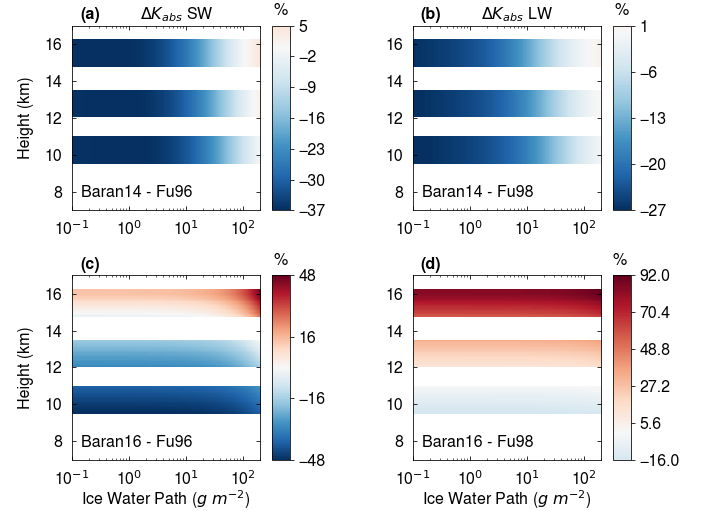

In [35]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 7.1 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for schi in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if schi == 0:
        # For SW:
        vmini_sw   = -37
        vmaxi_sw   = 5
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 7)
        cmap_sw    = 'RdBu_r'
        norm_sw    = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        
        #For LW:
        vmini_lw   = -27
        vmaxi_lw   = 1
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 5)
        cmap_lw    = 'RdBu_r'
        norm_lw    = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)
        
        labelpad   = -45
    else:
        # For SW:
        vmini_sw   = -48
        vmaxi_sw   = 48
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 4)
        cmap_sw    = 'RdBu_r'
        norm_sw    = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        
        #For LW:
        vmini_lw   = -16
        vmaxi_lw   = 92
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'RdBu_r'
        norm_lw    = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)
        
        labelpad   = -45
         
    # Shortwave K_abs Difference
    im = ax[schi, 0].imshow(K_abs_sw_t3_bb_diff_plot_RD[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #if schi == 0: cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 0].set_title(r'$\Delta K_{abs}$ SW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)
    
    if schi == 1: labelpad = -60
    # Longwave K_abs Difference
    im = ax[schi, 1].imshow(K_abs_lw_t3_bb_diff_plot_RD[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 1].set_title(r'$\Delta K_{abs}$ LW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis:
yticks      = np.arange(0, profi+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis: # Logscale ticklabels are built manually:
major_xticklabels = np.logspace(np.log10(0.1), np.log10(100), 4)
minor_xticklabels = list(np.linspace(0.1, 1, 10))[:-1] + list(np.linspace(1, 10, 10))[:-1] + list(np.linspace(10, 100, 10)) + [200]
major_xticks      = []
minor_xticks      = []
for xticklabelsi in major_xticklabels:
    major_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])
for xticklabelsi in minor_xticklabels:
    minor_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Ice Water Path ($g$ $m^{-2}$)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 0)
        ax[diff, j].set_xticks(major_xticks)
        ax[diff, j].set_xticks(minor_xticks, minor = True)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        ax[diff, j].tick_params(axis = 'x', which = 'minor', color = 'black',
                                size = 2, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)   
        #ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(major_xticklabels)
        ax[diff, j].set_xticklabels([r'10$^{-1}$', r'10$^{0}$', r'10$^{1}$', r'10$^{2}$'])
        #ax[diff, j].set_xlim(0.1, 2000)
        #ax[diff, j].set_xscale('log')
        
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.05, 0.05, Diff_sw[diff],
                             ha = 'left', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.05, 0.05, Diff_lw[diff],
                             ha = 'left', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 7).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.1, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_Kext_barans_Rdiff_SM_v2c.png', dpi=500)

Saving colorbar characteristics per scheme (tickbars, cmap, norm, labelpad):

In [36]:
K_abs_sw_t3_bb_RD_colorbar = [[np.linspace(-37, 5, 4), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -37, vmax = 5)],
                              [np.linspace(-48, 48, 4), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -48, vmax = 48)]]
K_abs_lw_t3_bb_RD_colorbar = [[np.linspace(-27, 1, 5), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -27, vmax = 1)],
                              [np.linspace(-16, 92, 6), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -16, vmax = 92)]]

## Asymmetry Parameter g:

Position of 30 um (Fixed Size). Already defined for Extinction Coefficient:

In [37]:
fu_sw_g = fu_sw.g.values
fu_lw_g = fu_lw.g.values
baran14_sw_g = baran14_sw.g.values
baran14_lw_g = baran14_lw.g.values
baran16_sw_g = baran16_sw.g.values
baran16_lw_g = baran16_lw.g.values

I like to check the table in excel:

In [38]:
# np.savetxt('fu_lw_g.csv', fu_lw_g[:,pos30,0], delimiter = ",")
# np.savetxt('b14_lw_g.csv', baran14_lw_g, delimiter = ",")

Be careful, compute only until 200 g m$^{-2}$:

In [39]:
lim200 = np.where(iwp == min(iwp, key = lambda x: abs(x - 200)))[0][0]

In [40]:
#iwpi  = test3_201_in.sizes['column']     # Temperature Levels
profi = test3_201_in.sizes['half_level']  # Vertical Profile

sw_bands = list(np.arange(0,13)[::-1])
lw_bands = list(np.arange(1,16)[::-1])

## g Calculation Matrices:
g_sw_t3_bb = np.zeros((3, len(iwp[:lim200]), profi))
g_lw_t3_bb = np.zeros((3, len(iwp[:lim200]), profi))

## Matrices for plotting:
g_sw_t3_bb_plot = np.zeros((3, profi, len(iwp[:lim200])))
g_lw_t3_bb_plot = np.zeros((3, profi, len(iwp[:lim200])))

for sch in range(3): # per optical scheme (1,3): Fu, Baran14, Baran16
    for i in range(len(iwp[:lim200])):
        pres     = test3_201_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = test3_qice[i]                      # Ice Water Mixing Ratio (kg / kg) from logscale input file
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: # If there is no Ice cloud, Kext = 0
                g_sw_t3_bb[sch, i, q_ix] = 0
                g_lw_t3_bb[sch, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_qidiff   = q_difference.argmin()
                #print(sch, i, min_i)
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                fu_sw_bb_g  = 0
                b14_sw_bb_g = 0
                b16_sw_bb_g = 0
                for sw_band in sw_bands:
                    Dl = 1e4/fu_sw_wn1[sw_band] - 1e4/fu_sw_wn2[sw_band]
                    fu_sw_bb_g  += fu_sw_g[sw_band, pos30]*Dl
                    b14_sw_bb_g += baran14_sw_g[sw_band, min_qidiff]*Dl
                    b16_sw_bb_g += baran16_sw_g[sw_band, min_qidiff, min_Tdiff]*Dl
                g_sw_t3_bb[0, i, q_ix] = fu_sw_bb_g
                g_sw_t3_bb[1, i, q_ix] = b14_sw_bb_g 
                g_sw_t3_bb[2, i, q_ix] = b16_sw_bb_g
                
                fu_lw_bb_g  = 0
                b14_lw_bb_g = 0
                b16_lw_bb_g = 0
                for lw_band in lw_bands:
                    Dl = 1e4/fu_lw_wn1[lw_band] - 1e4/fu_lw_wn2[lw_band]
                    fu_lw_bb_g  += fu_lw_g[lw_band, pos30]*Dl
                    b14_lw_bb_g += baran14_lw_g[lw_band, min_qidiff]*Dl
                    b16_lw_bb_g += baran16_lw_g[lw_band, min_qidiff, min_Tdiff]*Dl
                g_lw_t3_bb[0, i, q_ix] = fu_lw_bb_g
                g_lw_t3_bb[1, i, q_ix] = b14_lw_bb_g 
                g_lw_t3_bb[2, i, q_ix] = b16_lw_bb_g
                
    # For plotting:
    g_sw_t3_bb_plot[sch,:,:] = np.transpose(g_sw_t3_bb[sch,:,:])
    g_lw_t3_bb_plot[sch,:,:] = np.transpose(g_lw_t3_bb[sch,:,:])

### Figure with relative difference

In [41]:
# Shortwave:
g_sw_t3_bb_diff_plot_RD    = np.zeros((2, profi, len(iwp[:lim200])))
# Baran2014 - Fu
g_sw_t3_bb_diff_plot_RD[0] = ((g_sw_t3_bb_plot[1] - g_sw_t3_bb_plot[0])/g_sw_t3_bb_plot[0])*100
# Baran2016 - Fu
g_sw_t3_bb_diff_plot_RD[1] = ((g_sw_t3_bb_plot[2] - g_sw_t3_bb_plot[0])/g_sw_t3_bb_plot[0])*100

# Longwave:
g_lw_t3_bb_diff_plot_RD    = np.zeros((2, profi, len(iwp[:lim200])))
# Baran2014 - Fu
g_lw_t3_bb_diff_plot_RD[0] = ((g_lw_t3_bb_plot[1] - g_lw_t3_bb_plot[0])/g_lw_t3_bb_plot[0])*100
# Baran2016 - Fu
g_lw_t3_bb_diff_plot_RD[1] = ((g_lw_t3_bb_plot[2] - g_lw_t3_bb_plot[0])/g_lw_t3_bb_plot[0])*100

/tmp/ipykernel_13390/239652852.py:4: RuntimeWarning: invalid value encountered in divide
  g_sw_t3_bb_diff_plot_RD[0] = ((g_sw_t3_bb_plot[1] - g_sw_t3_bb_plot[0])/g_sw_t3_bb_plot[0])*100
/tmp/ipykernel_13390/239652852.py:6: RuntimeWarning: invalid value encountered in divide
  g_sw_t3_bb_diff_plot_RD[1] = ((g_sw_t3_bb_plot[2] - g_sw_t3_bb_plot[0])/g_sw_t3_bb_plot[0])*100
/tmp/ipykernel_13390/239652852.py:11: RuntimeWarning: invalid value encountered in divide
  g_lw_t3_bb_diff_plot_RD[0] = ((g_lw_t3_bb_plot[1] - g_lw_t3_bb_plot[0])/g_lw_t3_bb_plot[0])*100
/tmp/ipykernel_13390/239652852.py:13: RuntimeWarning: invalid value encountered in divide
  g_lw_t3_bb_diff_plot_RD[1] = ((g_lw_t3_bb_plot[2] - g_lw_t3_bb_plot[0])/g_lw_t3_bb_plot[0])*100


In [42]:
# Shortwave g differences:
print('Shortwave CRH Differences:')
b14_fu_min_sw = np.nanmin(g_sw_t3_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_sw)
b14_fu_max_sw = np.nanmax(g_sw_t3_bb_diff_plot_RD[0][np.nonzero(g_sw_t3_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_sw)
b16_fu_min_sw = np.nanmin(g_sw_t3_bb_diff_plot_RD[1])
print('Baran2016 - Fu min: ', b16_fu_min_sw)
b16_fu_max_sw = np.nanmax(g_sw_t3_bb_diff_plot_RD[1])
print('Baran2016 - Fu max: ', b16_fu_max_sw)

print('')
# Longwave g differences:
print('Longwave CRH Differences:')
b14_fu_min_lw = np.nanmin(g_lw_t3_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_lw)
b14_fu_max_lw = np.nanmax(g_lw_t3_bb_diff_plot_RD[0][np.nonzero(g_lw_t3_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_lw)
b16_fu_min_lw = np.nanmin(g_lw_t3_bb_diff_plot_RD[1][np.nonzero(g_lw_t3_bb_diff_plot_RD[1])])
print('Baran2016 - Fu min: ', b16_fu_min_lw)
b16_fu_max_lw = np.nanmax(g_lw_t3_bb_diff_plot_RD[1][np.nonzero(g_lw_t3_bb_diff_plot_RD[1])])
print('Baran2016 - Fu max: ', b16_fu_max_lw)

Shortwave CRH Differences:
Baran2014 - Fu min:  -3.814042645385955
Baran2014 - Fu max:  2.103082804000804
Baran2016 - Fu min:  -0.6232471239257154
Baran2016 - Fu max:  0.96729396779096

Longwave CRH Differences:
Baran2014 - Fu min:  -7.838263256945951
Baran2014 - Fu max:  5.736350656127763
Baran2016 - Fu min:  -0.2652038325789373
Baran2016 - Fu max:  2.78846065152212


<IPython.core.display.Javascript object>


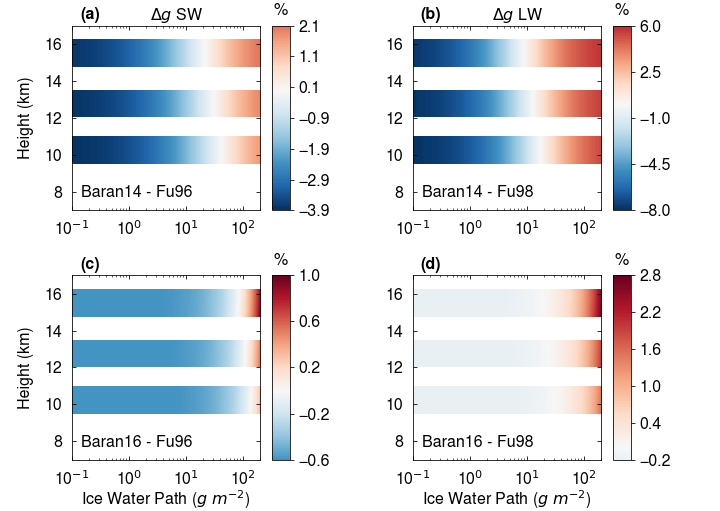

In [43]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 7.1 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for schi in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if schi == 0:
        # For SW:
        vmini_sw   = -3.9
        vmaxi_sw   = 2.1
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 7)
        cmap_sw    = 'RdBu_r'
        norm_sw    = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        
        #For LW:
        vmini_lw   = -8
        vmaxi_lw   = 6
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 5)
        cmap_lw    = 'RdBu_r'
        norm_lw    = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)
        
        labelpad   = -50
    else:
        # For SW:
        vmini_sw   = -0.6
        vmaxi_sw   = 1
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 5)
        cmap_sw    = 'RdBu_r'
        norm_sw    = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        
        #For LW:
        vmini_lw   = -0.2
        vmaxi_lw   = 2.8
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'RdBu_r'
        norm_lw    = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)
        
        labelpad   = -50
         
    # Shortwave g Difference
    im = ax[schi, 0].imshow(g_sw_t3_bb_diff_plot_RD[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #if schi == 0: cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 0].set_title(r'$\Delta g$ SW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)
    
    #if schi == 1: labelpad = -60
    # Longwave g Difference
    im = ax[schi, 1].imshow(g_lw_t3_bb_diff_plot_RD[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 1].set_title(r'$\Delta g$ LW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis:
yticks      = np.arange(0, profi+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis: # Logscale ticklabels are built manually:
major_xticklabels = np.logspace(np.log10(0.1), np.log10(100), 4)
minor_xticklabels = list(np.linspace(0.1, 1, 10))[:-1] + list(np.linspace(1, 10, 10))[:-1] + list(np.linspace(10, 100, 10)) + [200]
major_xticks      = []
minor_xticks      = []
for xticklabelsi in major_xticklabels:
    major_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])
for xticklabelsi in minor_xticklabels:
    minor_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Ice Water Path ($g$ $m^{-2}$)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 0)
        ax[diff, j].set_xticks(major_xticks)
        ax[diff, j].set_xticks(minor_xticks, minor = True)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        ax[diff, j].tick_params(axis = 'x', which = 'minor', color = 'black',
                                size = 2, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)   
        #ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(major_xticklabels)
        ax[diff, j].set_xticklabels([r'10$^{-1}$', r'10$^{0}$', r'10$^{1}$', r'10$^{2}$'])
        #ax[diff, j].set_xlim(0.1, 2000)
        #ax[diff, j].set_xscale('log')
        
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.05, 0.05, Diff_sw[diff],
                             ha = 'left', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.05, 0.05, Diff_lw[diff],
                             ha = 'left', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 7).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.1, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_Kext_barans_Rdiff_SM_v2c.png', dpi=500)

Saving colorbar characteristics per scheme (tickbars, cmap, norm):

In [44]:
g_sw_t3_bb_RD_colorbar = [[np.linspace(-3.9, 2.1, 7), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -3.9, vmax = 2.1)],
                          [np.linspace(-0.6, 1, 5), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -0.6, vmax = 1)]]
g_lw_t3_bb_RD_colorbar = [[np.linspace(-8, 6, 5), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -8, vmax = 6)],
                          [np.linspace(-0.2,2.8, 6), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -0.2, vmax = 2.8)]]

## Figure S13

<IPython.core.display.Javascript object>


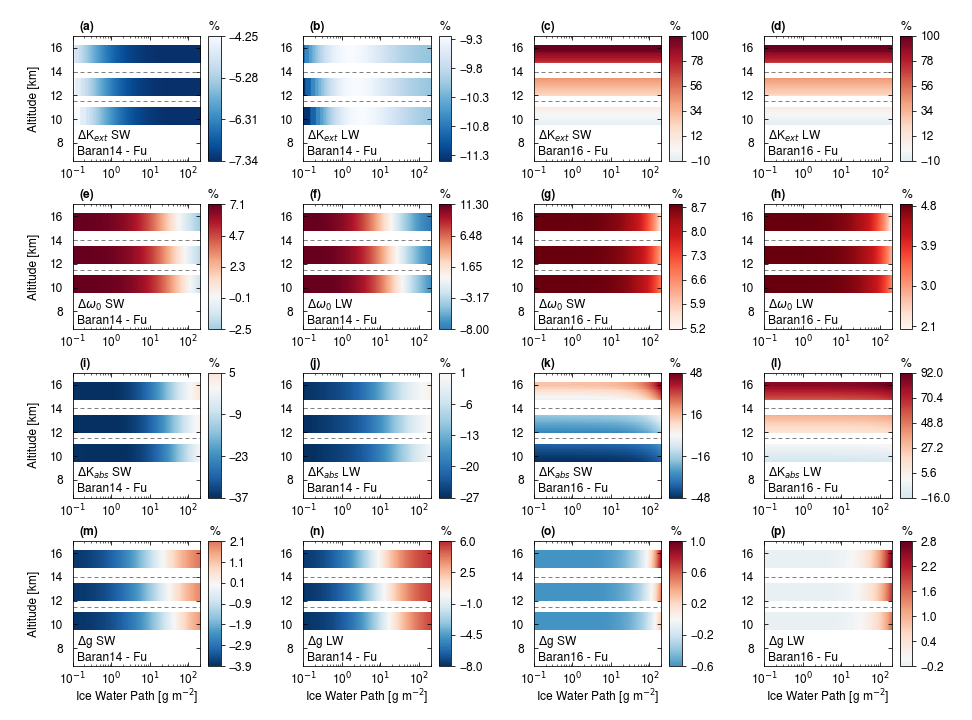

In [63]:
fontname = 'Nimbus Sans' # Arial
fontsize = 12
fheigth  = 10 # inches
flength  = 13.5 # inches

rows    = 4
columns = 4
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.075, left = 0.075, right = 0.95, 
                    hspace = .35, wspace = .45)

opt_props = ['K_ext', 'ssa', 'K_abs', 'g']
rad_comps = ['sw', 'lw']
diff_props_label = [r'$\Delta$K$_{ext}$', r'$\Delta\omega_0$', r'$\Delta$K$_{abs}$', r'$\Delta$g']
rad_label        = ['SW', 'LW']

Diff          = ['Baran14 - Fu', 'Baran16 - Fu']
panel_letters = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)',
                 '(i)','(j)','(k)','(l)','(m)','(n)','(o)','(p)']
labelpadi     = [-45,-45,-35,-35,
                 -40,-45,-30,-30,
                 -35,-35,-35,-45,
                 -37.5,-37.5,-37.5,-37.5]

panel_i = 0
# COLORMAPS
for row in range(rows):
    for col in range(columns):
        if col == 0: radi = 0; schi = 0
        if col == 1: radi = 1; schi = 0
        if col == 2: radi = 0; schi = 1
        if col == 3: radi = 1; schi = 1
        to_plot     = eval(opt_props[row] + '_' + rad_comps[radi] + '_t3_bb_diff_plot_RD')[schi]
        colobar_set = eval(opt_props[row] + '_' + rad_comps[radi] + '_t3_bb_RD_colorbar')[schi]

        im = ax[row, col].imshow(to_plot, cmap = colobar_set[1], aspect = 'auto',
                                 norm = colobar_set[2])
        cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = colobar_set[0])
        cbar.set_label('%', labelpad = labelpadi[panel_i], y = 1.12, rotation=0, 
                       fontsize = fontsize, fontname = fontname)
        cbar.ax.tick_params(labelsize = fontsize, pad = 5)
        #if schi == 0: cbar.formatter.set_powerlimits((0, 0))
        cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
        for tick in cbar.ax.get_yticklabels():
            tick.set_fontname(fontname)
            
        ax[row, col].axhline((height_hl_pd - 11.5).abs().argmin(),
                             dashes=[4, 3], color = 'grey', linewidth = 1)
        ax[row, col].axhline((height_hl_pd - 14).abs().argmin(),
                             dashes=[4, 3], color = 'grey', linewidth = 1)  
            
#         ax[row, col].set_title(diff_props_label[row] + ' ' + rad_label[radi], 
#                                color = 'black', x = 0.555, y = 1,
#                                fontsize = fontsize, fontname = fontname)
        
        # AXIS PARAMETERS
        # X Axis: # Logscale ticklabels are built manually:
        major_xticklabels = np.logspace(np.log10(0.1), np.log10(100), 4)
        minor_xticklabels = list(np.linspace(0.1, 1, 10))[:-1] + list(np.linspace(1, 10, 10))[:-1] + list(np.linspace(10, 100, 10)) + [200]
        major_xticks      = []
        minor_xticks      = []
        for xticklabelsi in major_xticklabels:
            major_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])
        for xticklabelsi in minor_xticklabels:
            minor_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])
        if row == 3:
            ax[row,col].set_xlabel(r'Ice Water Path [g m$^{-2}$]', 
                                   fontsize = fontsize, fontname = fontname,
                                   color = 'black', labelpad = 0)
        ax[row,col].set_xticks(major_xticks)
        ax[row,col].set_xticks(minor_xticks, minor = True)
        ax[row,col].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 5)
        ax[row,col].tick_params(axis = 'x', which = 'minor', color = 'black',
                                size = 2, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[row, col].get_xticklabels():
            tick.set_fontname(fontname)
        #ax[row, col].set_xticklabels(major_xticklabels)
        ax[row, col].set_xticklabels([r'10$^{-1}$', r'10$^{0}$', r'10$^{1}$', r'10$^{2}$'])
           
        # Y Axis:
        yticks      = np.arange(0, profi+1, 8) # altitude tick labels
        # height tickLabels are rounded for visualization:
        yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
        ax[row, col].tick_params(axis = 'y', which = 'major', color = 'black',
                                 size = 4, direction = 'in', right = True,
                                 labelsize = fontsize, pad = 10)
        for tick in ax[row, col].get_yticklabels():
            tick.set_fontname(fontname)
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(yticklabels)
        if col == 0:
            ax[row, col].set_ylabel('Altitude [km]', fontsize = fontsize, fontname = fontname,
                                    color ='black', labelpad = 10)
        ax[row, col].text(0.03, 0.02, diff_props_label[row] + ' ' + rad_label[radi] + '\n' + Diff[schi],
                          ha = 'left', va = 'bottom', transform = ax[row, col].transAxes,
                          fontsize = fontsize, fontname = fontname, color = 'black')
        ax[row, col].set_ylim((height_hl_pd - 6.5).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[row, col].text(0.05, 1.025, panel_letters[panel_i], weight = 'bold',
                         ha = 'left', va = 'bottom', transform = ax[row, col].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/paper_figures/')
plt.savefig(out_dir + 'fs13.pdf', dpi = 300)